In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import MaxPooling2D as MaxPool2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['chest-xray-pneumonia']


In [2]:
labels = ['PNEUMONIA', 'NORMAL']
image_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for image in os.listdir(path):
             try:
                img_array = cv2.imread(os.path.join(path,image))
    
                resized_arr = cv2.resize(img_array, (image_size, image_size))
                data.append([resized_arr, class_num])
             except Exception as e:
                print(e)
                
    return np.array(data)
#, cv2.IMREAD_GRAYSCALE

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/tmp/ipykernel_24/3737204920.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<Axes: ylabel='count'>

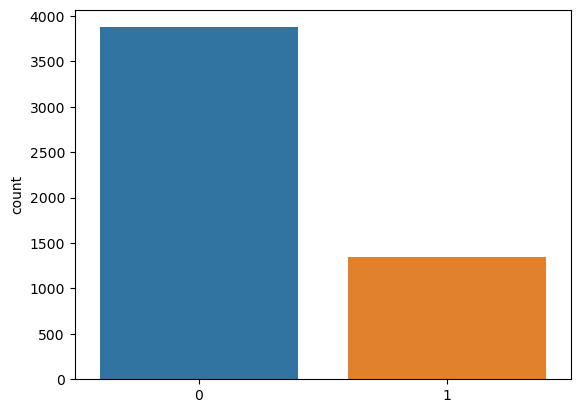

In [4]:
class_labels = train[:, 1]

# Convert the class labels to a list
class_labels_list = class_labels.tolist()

# Plot the countplot
sns.countplot(x=class_labels_list)

In [5]:
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for array, label in train:
    X_train.append(array)
    y_train.append(label)
    
for array, label in test:
    X_test.append(array)
    y_test.append(label)
    
for array, label in val:
    X_val.append(array)
    y_val.append(label)

In [6]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_val = np.array(X_val) / 255

In [7]:
X_train = X_train.reshape(-1, image_size, image_size, 3)
y_train = np.array(y_train)

X_test = X_test.reshape(-1, image_size, image_size, 3)
y_test = np.array(y_test)

X_val = X_val.reshape(-1, image_size, image_size, 3)
y_val = np.array(y_val)

In [8]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [9]:
'''train_aug = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=False,
    #shear_range=0.1,
    zoom_range=0.2
)
'''
train_aug = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [10]:
train_aug.fit(X_train)

In [11]:
#Accuracy of the model is -  91.82692170143127 % and 92.147
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (image_size,image_size,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [12]:
'''model = Sequential()

model.add(Conv2D(64, (3,3),strides = 1, padding='same', activation='relu',input_shape=(image_size, image_size,3)))
model.add(BatchNormalization()),
model.add(MaxPooling2D((2,2),strides=(2,2))),
    
model.add(Conv2D(128, (3,3),strides = 1, padding='same', activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2,2),strides=2)),
model.add(Dropout(0.2)),
    
model.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),
model.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2,2),strides=2)),
model.add(Dropout(0.2)),
    
model.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),
model.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2,2),strides=2)),
model.add(Dropout(0.2)),
    
model.add(Conv2D(512, (3,3),strides = 1, padding='same', activation='relu')),
model.add(Conv2D(512, (3,3),strides = 1, padding='same', activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2,2),strides=2)),
    
model.add(Flatten()),
model.add(Dense(4096, activation='relu')),
model.add(BatchNormalization()),
model.add(Dropout(0.5)),

model.add(Dense(2048, activation='relu')),
model.add(BatchNormalization()),
model.add(Dropout(0.5)),

model.add(Dense(256, activation='relu')),
model.add(BatchNormalization()),

model.add(Dense(2, activation='softmax'))'''

"model = Sequential()\n\nmodel.add(Conv2D(64, (3,3),strides = 1, padding='same', activation='relu',input_shape=(image_size, image_size,3)))\nmodel.add(BatchNormalization()),\nmodel.add(MaxPooling2D((2,2),strides=(2,2))),\n    \nmodel.add(Conv2D(128, (3,3),strides = 1, padding='same', activation='relu')),\nmodel.add(BatchNormalization()),\nmodel.add(MaxPooling2D((2,2),strides=2)),\nmodel.add(Dropout(0.2)),\n    \nmodel.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),\nmodel.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),\nmodel.add(BatchNormalization()),\nmodel.add(MaxPooling2D((2,2),strides=2)),\nmodel.add(Dropout(0.2)),\n    \nmodel.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),\nmodel.add(Conv2D(256, (3,3),strides = 1, padding='same', activation='relu')),\nmodel.add(BatchNormalization()),\nmodel.add(MaxPooling2D((2,2),strides=2)),\nmodel.add(Dropout(0.2)),\n    \nmodel.add(Conv2D(512, (3,3),strides = 1, padding='

In [13]:
#model.summary()

In [14]:
#model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
#,callbacks = [learning_rate_reduction]

In [16]:
class_weights = {0: 0.4, 1: 1.0}
history = model.fit(train_aug.flow(X_train,y_train,batch_size=32), epochs=12, 
                    validation_data=(train_aug.flow(X_val,y_val)),
                    class_weight=class_weights,
                    callbacks = [learning_rate_reduction])

Epoch 1/12


2023-07-02 11:48:29.334234: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 38s 167ms/step - loss: 0.2580 - accuracy: 0.8340 - val_loss: 9.6817 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 27s 165ms/step - loss: 0.1376 - accuracy: 0.9049 - val_loss: 9.4083 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9206
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 27s 165ms/step - loss: 0.1163 - accuracy: 0.9206 - val_loss: 6.9353 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 26s 161ms/step - loss: 0.0903 - accuracy: 0.9446 - val_loss: 2.2225 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 26s 159ms/step - loss: 0.0884 - accuracy: 0.9433 - val_loss: 2.7106 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
163/163 [==============================] 

In [17]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 9ms/step - loss: 0.2526 - accuracy: 0.9006
Loss of the model is -  0.2525634169578552
20/20 [==============================] - 0s 9ms/step - loss: 0.2526 - accuracy: 0.9006
Accuracy of the model is -  90.06410241127014 %


In [18]:
# After training
model.save('/kaggle/working/my_model.h5')

In [19]:
from IPython.display import FileLink

# Specify the file path of the saved model
file_path = '/kaggle/working/my_model.h5'

# Create a download link
link = FileLink(file_path)

# Display the download link
link

/kaggle/working/my_model.h5

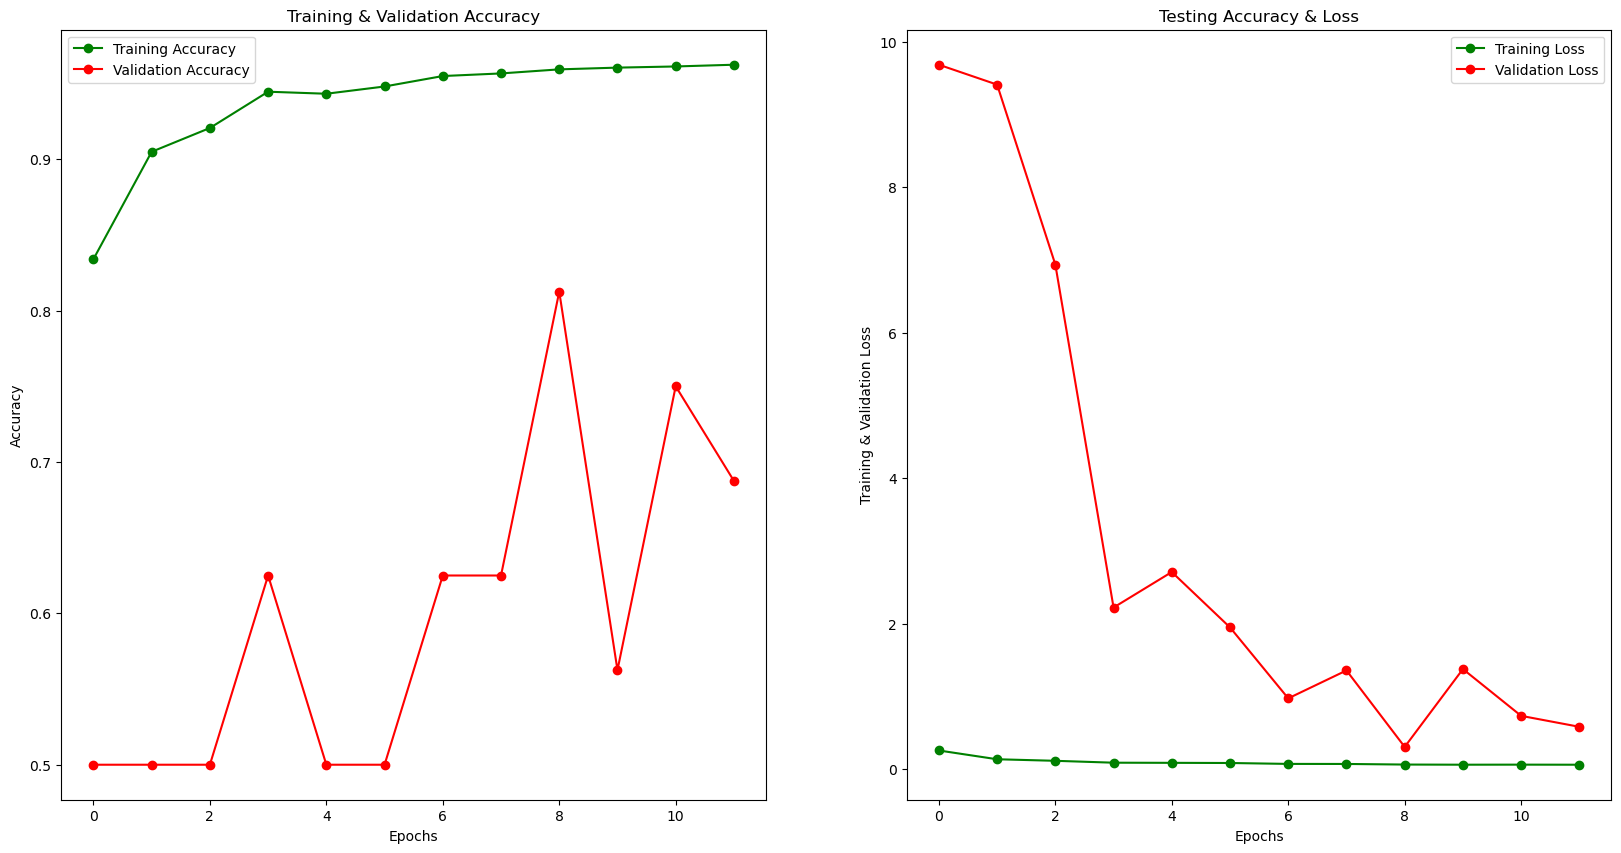

In [20]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [21]:
predictions = model.predict(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 0s 7ms/step


array([4.18792903e-01, 5.06963916e-02, 2.31155619e-01, 3.85416934e-04,
       4.44898754e-03, 4.52763587e-01, 5.42657450e-02, 4.60051075e-02,
       1.24214076e-01, 6.09008789e-01, 8.37023795e-01, 9.23228681e-01,
       9.37009081e-02, 3.22433212e-03, 1.02519644e-02], dtype=float32)

In [22]:
#print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))